In [2]:
#### IMPORT PACKAGES
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from transformers import pipeline
import seaborn as sns

# add parent directory to the Python path
sys.path.append("..")

/home/coder/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-21 14:10:49.481415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#### INITIALIZE HUGGINGFACE PIPELINE
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
/home/coder/.local/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [4]:
##### READ IN DATA
filename = os.path.join("..","in", "fake_or_real_news.csv")
data = pd.read_csv(filename, index_col = 0)
data = data.reset_index(drop = True) # this was added to prevent errors in the for loop
headlines = data["title"]
fake_or_real = data["label"] # label here refers to fake/real

In [20]:
# create empty df to store results
results_df = pd.DataFrame(columns=["real/fake", "emotion", "count", "proportion"])

# Only going through the first 100 headlines to save time while testing
for i, headline in enumerate(headlines[:100]):
    preds = classifier(headline)
    top_emotion = max(preds[0], key=lambda x:x['score'])
    predicted_emotion = top_emotion['label']
    news_label = fake_or_real[i]

    # append predicted emotion and real/fake label to the df
    results_df.loc[len(results_df)] = [news_label, predicted_emotion, 1, None]

# group results by "real/fake" and "emotion" and sum the counts
grouped_results_df = results_df.groupby(["real/fake", "emotion"], as_index=False)["count"].sum()

# calculate the total count for each "real/fake" group
total_count = grouped_results_df.groupby("real/fake", as_index=False)["count"].sum()

# calculate the proportion for each group
results_df["proportion"] = results_df.apply(lambda x: x["count"] / total_count[total_count["real/fake"] == x["real/fake"]]["count"].values[0], axis=1)

# group the results by "real/fake" and "emotion" again and sum the counts and proportions
grouped_results_df = results_df.groupby(["real/fake", "emotion"], as_index=False).agg({"count": "sum", "proportion": "sum"})

# Round to 3 decimal places
grouped_results_df = grouped_results_df.round(3)

# create "out" folder (if it doesn't exist)
out_dir = os.path.join("..", "out")
os.makedirs(out_dir, exist_ok=True)

# save results to a CSV file
grouped_results_df.to_csv(os.path.join(out_dir, "emotion proportions.csv"), index=False)

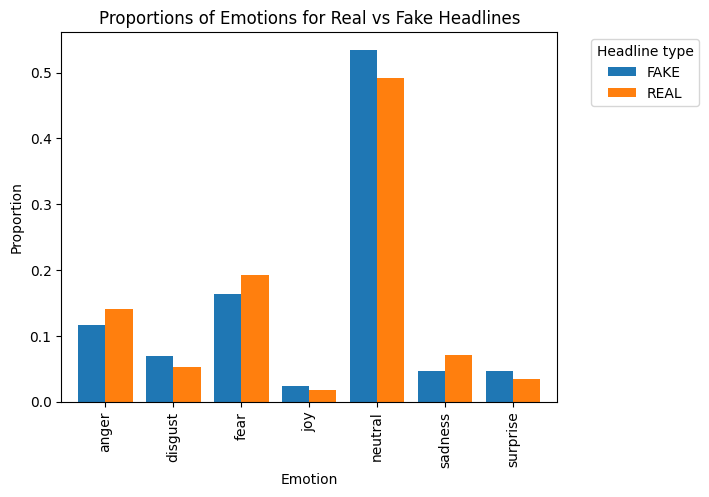

In [19]:
# create a pivot table to arrange the data in the desired format
pivot_df = grouped_results_df.pivot(index="emotion", columns="real/fake", values="proportion")
# sort the pivot table by the index
pivot_df = pivot_df.reindex(index=sorted(pivot_df.index))

# create the bar chart
ax = pivot_df.plot(kind='bar', width=0.8)
ax.set_xlabel("Emotion")
ax.set_ylabel("Proportion")
ax.set_title("Proportions of Emotions for Real vs Fake Headlines")

# add the values above each bar
#for i in range(len(pivot_df.index)):
#    for j in range(len(pivot_df.columns)):
#        plt.text(x=i*2+j-0.15, y=pivot_df.iloc[i,j]+0.01, s="{:.1%}".format(pivot_df.iloc[i,j]), fontsize=10)

# add the legend
plt.legend(title="Headline type", loc='upper right', bbox_to_anchor=(1.3, 1))

# show the plot
plt.show()

# create "out" folder (if it doesn't exist)
out_dir = os.path.join("..", "out")
os.makedirs(out_dir, exist_ok=True)

# save plot in the "out" folder
ax.figure.savefig(os.path.join(out_dir, "emotion proportions.png"), bbox_inches='tight')